In [1]:
import os
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations
import matplotlib as mpl
from matplotlib import pyplot as plt
import multiprocessing as mp

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import PartialDependenceDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap
import seaborn as sns

%config InlineBackend.figure_format = "retina"

Plan:

1. Feature selection: condition number and VIF
2. Data preparation: scaler, label encoding
3. Hyparparameters tuning with CV, penalty=L2
4. Model interpretation

In [2]:
# Configuration
TEST_SIZE = 0.2
SEED = 42
CROSSVAL_SIZE = 5
CLASS_NAMES = ["tripustulatus", "punctatus", "pabulinus"]
# CLASS_IDS = [idx for idx in range(len(CLASS_NAMES))]
SCORING = "roc_auc"
PENALTY = "l2"
COLOR_MAP =  {name: color for name,color in zip(CLASS_NAMES, ["#DD8D29", "#E2D200", "#46ACC8"]) }
# What pair of classes to use
CLASSES = ["tripustulatus", "pabulinus"]

### Reading data

In [3]:
filepath = os.path.join("data", "df_bio.csv")
if "df_bio.csv" in os.listdir("data"):
    print("Reading existing full table")
    df_bio = pd.read_csv(filepath)
else:
    print("Preparing full table")
    df_bio = pd.concat([pd.read_csv(os.path.join("data", name)) for name in os.listdir("data")])
    df_bio = df_bio.reset_index(drop=True)
    df_bio = df_bio.sample(frac=1)
    df_bio.to_csv(filepath, index=False)

Reading existing full table


In [4]:
df_bio = df_bio[df_bio["species"].isin(CLASSES)]

In [5]:
df_bio.head(10)

,species,longitude,latitude,bio01,bio02,bio03,bio04,bio05,bio06,bio07,...,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,tripustulatus,-2.904473,43.304850,136,64,36,4025,231,58,173,...,189,87,1203,156,48,29,406,190,222,406
2,tripustulatus,27.826083,44.089939,113,84,27,7714,268,-33,301,...,210,12,483,58,31,19,154,95,144,104
3,pabulinus,134.400000,46.200000,25,108,21,13833,253,-240,493,...,189,-167,676,133,10,70,336,40,336,40
4,tripustulatus,40.620000,43.100000,144,83,32,6118,275,22,253,...,221,67,1447,151,93,14,426,310,338,388
5,pabulinus,73.773660,62.120300,-34,87,18,13715,217,-265,482,...,144,-209,556,78,21,39,219,76,219,87
6,pabulinus,84.969000,56.424000,8,97,21,12953,250,-211,461,...,172,-162,535,72,20,38,205,70,205,89
7,pabulinus,36.063910,69.116540,-2,62,21,7631,155,-137,292,...,99,-95,464,56,21,30,159,70,159,90
8,pabulinus,91.400000,51.266670,-23,125,22,15414,239,-311,550,...,160,-236,312,64,7,68,163,24,163,27
9,tripustulatus,41.815000,42.534000,142,91,34,6427,279,13,266,...,222,59,1759,180,89,18,511,336,509,428
11,pabulinus,10.292488,56.236434,77,68,27,6016,201,-43,244,...,154,2,599,63,33,22,185,104,169,115


In [6]:
df_bio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 0 to 593
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   species    489 non-null    object 
 1   longitude  489 non-null    float64
 2   latitude   489 non-null    float64
 3   bio01      489 non-null    int64  
 4   bio02      489 non-null    int64  
 5   bio03      489 non-null    int64  
 6   bio04      489 non-null    int64  
 7   bio05      489 non-null    int64  
 8   bio06      489 non-null    int64  
 9   bio07      489 non-null    int64  
 10  bio08      489 non-null    int64  
 11  bio09      489 non-null    int64  
 12  bio10      489 non-null    int64  
 13  bio11      489 non-null    int64  
 14  bio12      489 non-null    int64  
 15  bio13      489 non-null    int64  
 16  bio14      489 non-null    int64  
 17  bio15      489 non-null    int64  
 18  bio16      489 non-null    int64  
 19  bio17      489 non-null    int64  
 20  bio18      489 

### Feature selection

In [7]:
def best_feats_via_cond_number(df: pd.DataFrame, n_limit: int) -> pd.DataFrame:
    
    """
    Find best features combination of size n based on matrix condition number value
    """
    all_features = get_features(df)
    
    output = dict()
    
    for n in tqdm.notebook.tqdm(list(range(1, n_limit + 1))):

        best_feats = None
        best_cond_val = np.inf
        coms = list(combinations(all_features, n))

        for feats_combination in tqdm.notebook.tqdm(coms):

            cond_val = np.linalg.cond(df[[*feats_combination]].values)

            if cond_val < best_cond_val:
                best_cond_val = cond_val
                best_feats = feats_combination
                
        output.update({n: {"BestConditionVal": best_cond_val, "Features": best_feats}})
        
    return pd.DataFrame(output).T

In [8]:
def get_features(df: pd.DataFrame) -> list[str]:
    """
    Extract features from full table
    """
    to_exclude = ["longitude", "latitude", "species"]
    features = [x for x in df.columns.tolist() if x not in to_exclude]
    return features

In [9]:
# df_res = best_feats_via_cond_number(df_bio, 9)
# df_res.to_csv("df_res_lio_pub.csv", index=False)
df_res = pd.read_csv("df_res_lio_pub.csv")
df_res

,BestConditionVal,Features
0,1.000000,"('bio01',)"
1,1.093116,"('bio09', 'bio13')"
2,3.513412,"('bio08', 'bio09', 'bio17')"
3,4.679309,"('bio01', 'bio09', 'bio11', 'bio17')"
4,6.195254,"('bio08', 'bio09', 'bio11', 'bio13', 'bio17')"
5,9.779524,"('bio01', 'bio09', 'bio11', 'bio13', 'bio17', ..."
6,15.321818,"('bio08', 'bio09', 'bio10', 'bio11', 'bio13', ..."
7,25.657122,"('bio02', 'bio08', 'bio09', 'bio10', 'bio11', ..."
8,42.950593,"('bio01', 'bio02', 'bio08', 'bio09', 'bio11', ..."


In [10]:
df_res

,BestConditionVal,Features
0,1.000000,"('bio01',)"
1,1.093116,"('bio09', 'bio13')"
2,3.513412,"('bio08', 'bio09', 'bio17')"
3,4.679309,"('bio01', 'bio09', 'bio11', 'bio17')"
4,6.195254,"('bio08', 'bio09', 'bio11', 'bio13', 'bio17')"
5,9.779524,"('bio01', 'bio09', 'bio11', 'bio13', 'bio17', ..."
6,15.321818,"('bio08', 'bio09', 'bio10', 'bio11', 'bio13', ..."
7,25.657122,"('bio02', 'bio08', 'bio09', 'bio10', 'bio11', ..."
8,42.950593,"('bio01', 'bio02', 'bio08', 'bio09', 'bio11', ..."


In [11]:
def get_vif(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """
    Generate VIF table for a set of desired features
    """
    vif_data = pd.DataFrame() 
    vif_data["feature"] = df[features].columns 
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) 
                              for i in range(len(df[features].columns))] 
    vif_data["VIF"] = vif_data["VIF"].apply(lambda x: np.around(x, 3))
    vif_data = vif_data.sort_values(by=["VIF"], ascending=False)

    return vif_data

In [12]:
selected_features = [*eval(df_res.iloc[5]["Features"])]
get_vif(df_bio, selected_features)

,feature,VIF
5,bio19,15.715
4,bio17,11.144
3,bio13,7.850
1,bio09,6.854
0,bio01,6.083
2,bio11,5.099


In [13]:
selected_features = [*eval(df_res.iloc[4]["Features"])]
get_vif(df_bio, selected_features)

,feature,VIF
3,bio13,6.231
2,bio11,5.066
0,bio08,5.035
4,bio17,4.989
1,bio09,3.928


We use features `['bio08', 'bio09', 'bio11', 'bio13, 'bio17']` because their combination generates VIF metrics < 10 according to the rule of thumb.

In [14]:
SELECTED_FEATURES = selected_features

### Data preparation

In [15]:
df_prepared = df_bio.copy(deep=True)
df_prepared["species"] = df_prepared["species"].apply(lambda x: CLASSES.index(x))

In [16]:
X, y = df_prepared[SELECTED_FEATURES], df_prepared["species"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=np.random.RandomState(SEED),
                                                    stratify=y)

In [17]:
X_test.head()

,bio08,bio09,bio11,bio13,bio17
302,-9,136,-22,116,273
193,141,-33,-84,84,105
345,147,-21,-66,83,105
265,179,-10,-26,98,93
61,169,18,5,95,126


In [18]:
y.value_counts()

species
1    246
0    243
Name: count, dtype: int64

In [19]:
y_test.value_counts()

species
1    49
0    49
Name: count, dtype: int64

In [20]:
y_train.value_counts()

species
1    197
0    194
Name: count, dtype: int64

### Hyperparams tuning 

Standard cross-validation

In [21]:
logreg_cv = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model",
     LogisticRegressionCV(cv=CROSSVAL_SIZE,
                          penalty=PENALTY,
                          scoring=SCORING,
                          Cs=np.linspace(0.001, 0.5, 100))),
])

In [22]:
logreg_cv.fit(X=X_train[SELECTED_FEATURES], y=y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegressionCV(Cs=array([0.001     , 0.0060404 , 0.01108081, 0.01612121, 0.02116162,
       0.02620202, 0.03124242, 0.03628283, 0.04132323, 0.04636364,
       0.05140404, 0.05644444, 0.06148485, 0.06652525, 0.07156566,
       0.07660606, 0.08164646, 0.08668687, 0.09172727, 0.09676768,
       0.10180808, 0.10684848, 0.11188889, 0.11692929, 0.121969...
       0.32862626, 0.33366667, 0.33870707, 0.34374747, 0.34878788,
       0.35382828, 0.35886869, 0.36390909, 0.36894949, 0.3739899 ,
       0.3790303 , 0.38407071, 0.38911111, 0.39415152, 0.39919192,
       0.40423232, 0.40927273, 0.41431313, 0.41935354, 0.42439394,
       0.42943434, 0.43447475, 0.43951515, 0.44455556, 0.44959596,
       0.45463636, 0.45967677, 0.46471717, 0.46975758, 0.47479798,
       0.47983838, 0.48487879, 0.48991919, 0.4949596 , 0.5       ]),
                                      cv=5, scoring='roc_auc'))])

In [23]:
model_cv = logreg_cv[1]

In [24]:
model_cv.scores_[1]

array([[0.73012821, 0.75192308, 0.77179487, 0.78397436, 0.78782051,
        0.79102564, 0.79294872, 0.79615385, 0.79935897, 0.80128205,
        0.80448718, 0.80576923, 0.80512821, 0.80448718, 0.80576923,
        0.80512821, 0.80705128, 0.80769231, 0.80833333, 0.80897436,
        0.81025641, 0.81153846, 0.81153846, 0.81153846, 0.81282051,
        0.81282051, 0.81346154, 0.81282051, 0.81282051, 0.81346154,
        0.81346154, 0.81346154, 0.81346154, 0.81282051, 0.81282051,
        0.81346154, 0.81346154, 0.81346154, 0.81410256, 0.81410256,
        0.81410256, 0.81410256, 0.81410256, 0.81410256, 0.81346154,
        0.81346154, 0.81346154, 0.81282051, 0.81282051, 0.81282051,
        0.81282051, 0.81217949, 0.81217949, 0.81217949, 0.81217949,
        0.81217949, 0.81217949, 0.81217949, 0.81217949, 0.81217949,
        0.81217949, 0.81217949, 0.81282051, 0.81217949, 0.81217949,
        0.81282051, 0.81282051, 0.81282051, 0.81282051, 0.81282051,
        0.81282051, 0.81217949, 0.81282051, 0.81

In [25]:
[np.mean(x) for x in model_cv.scores_[1]]

[0.8093269230769231,
 0.7675328947368422,
 0.8196186719263641,
 0.6781525312294542,
 0.6661604207758056]

### Model explanation

In [26]:
model_cv.get_params()

{'Cs': array([0.001     , 0.0060404 , 0.01108081, 0.01612121, 0.02116162,
        0.02620202, 0.03124242, 0.03628283, 0.04132323, 0.04636364,
        0.05140404, 0.05644444, 0.06148485, 0.06652525, 0.07156566,
        0.07660606, 0.08164646, 0.08668687, 0.09172727, 0.09676768,
        0.10180808, 0.10684848, 0.11188889, 0.11692929, 0.1219697 ,
        0.1270101 , 0.13205051, 0.13709091, 0.14213131, 0.14717172,
        0.15221212, 0.15725253, 0.16229293, 0.16733333, 0.17237374,
        0.17741414, 0.18245455, 0.18749495, 0.19253535, 0.19757576,
        0.20261616, 0.20765657, 0.21269697, 0.21773737, 0.22277778,
        0.22781818, 0.23285859, 0.23789899, 0.24293939, 0.2479798 ,
        0.2530202 , 0.25806061, 0.26310101, 0.26814141, 0.27318182,
        0.27822222, 0.28326263, 0.28830303, 0.29334343, 0.29838384,
        0.30342424, 0.30846465, 0.31350505, 0.31854545, 0.32358586,
        0.32862626, 0.33366667, 0.33870707, 0.34374747, 0.34878788,
        0.35382828, 0.35886869, 0.36390909

In [27]:
model_cv.C_

array([0.13205051])

In [28]:
final_logreg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty=PENALTY, C=model_cv.C_[0], random_state=np.random.RandomState(SEED))
    ),
])
final_logreg.fit(X=X_train[SELECTED_FEATURES], y=y_train)

final_model = final_logreg[1]

In [29]:
print(
    classification_report(y_true=y_test,
                          y_pred=final_logreg.predict(X_test[SELECTED_FEATURES]),
                          target_names=CLASSES))

               precision    recall  f1-score   support

tripustulatus       0.58      0.76      0.65        49
    pabulinus       0.65      0.45      0.53        49

     accuracy                           0.60        98
    macro avg       0.61      0.60      0.59        98
 weighted avg       0.61      0.60      0.59        98



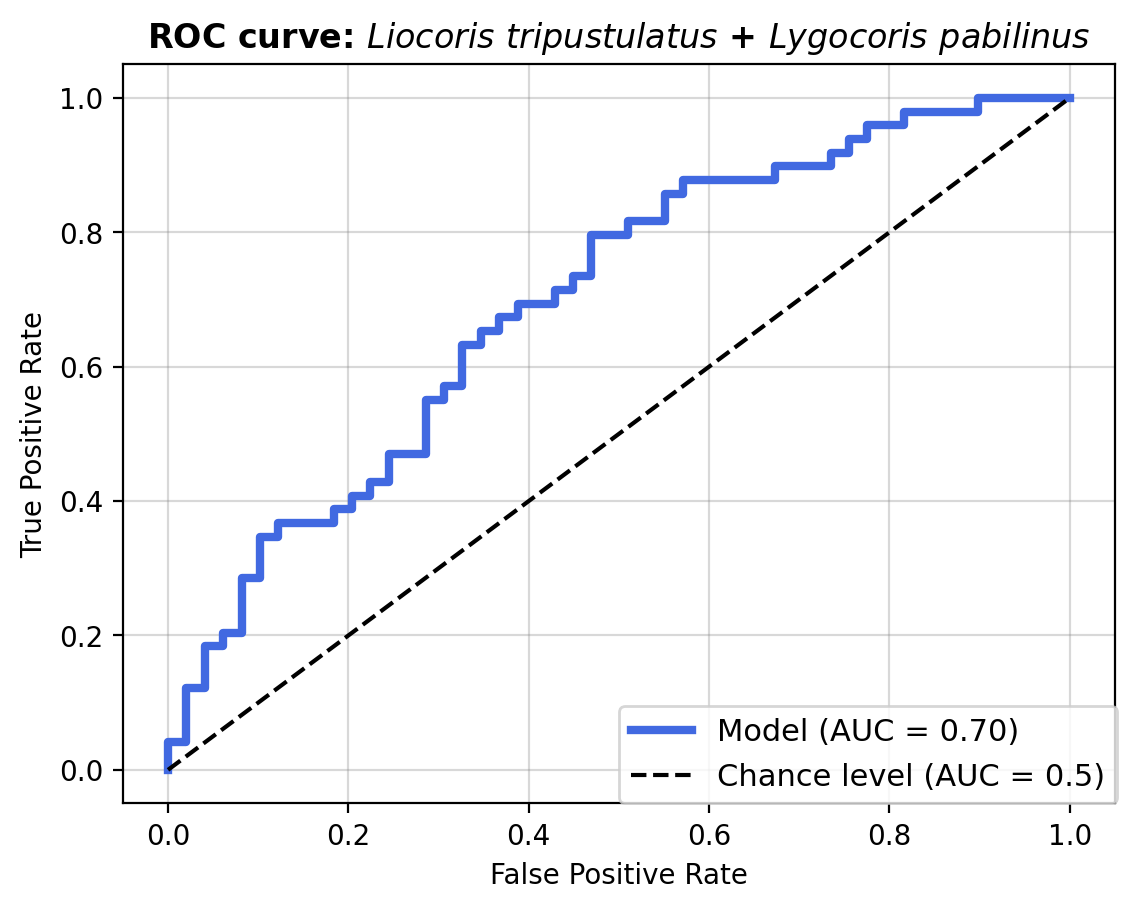

In [30]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    y_test.values,
    final_logreg.predict_proba(X_test[SELECTED_FEATURES])[:, 1],
    name=f"Model",
    color="royalblue",
    plot_chance_level=True,
    ax=ax,
    lw=3
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"ROC curve: $\it{Liocoris}$ $\it{tripustulatus}$ + $\it{Lygocoris}$ $\it{pabilinus}$", fontweight="bold") 
    
plt.legend(fontsize=11, loc=[0.5, 0])
ax.set_facecolor((1.0, 1.0, 1.0))
plt.grid(color="grey", alpha=0.3, which="both")
plt.savefig("roc_tri-pab.png", dpi=600)
plt.show()

Coefficients

In [31]:
df_final_coefs = pd.DataFrame({
    f"logreg": [final_model.intercept_[0], *final_model.coef_.tolist()[0]],
}, index = ["intercept", *SELECTED_FEATURES])
df_final_coefs.T

,intercept,bio08,bio09,bio11,bio13,bio17
logreg,0.049295,-0.321573,-0.869584,-0.224347,0.593941,0.212391


In [32]:
df_final = df_final_coefs.T

In [33]:
X_test_scaled = pd.DataFrame(logreg_cv[0].transform(X_test[SELECTED_FEATURES]), columns = SELECTED_FEATURES)
X_train_scaled = pd.DataFrame(logreg_cv[0].transform(X_train[SELECTED_FEATURES]), columns = SELECTED_FEATURES)
X_all_scaled = pd.DataFrame(logreg_cv[0].transform(X[SELECTED_FEATURES]), columns = SELECTED_FEATURES)

In [34]:
simple_explainer = shap.Explainer(
    final_model, X_train_scaled, feature_names=SELECTED_FEATURES
)
shap_values_train = simple_explainer.shap_values(X_train_scaled)
shap_values_test = simple_explainer.shap_values(X_test_scaled)
shap_all_values = simple_explainer.shap_values(X_all_scaled)

SHAP Summary

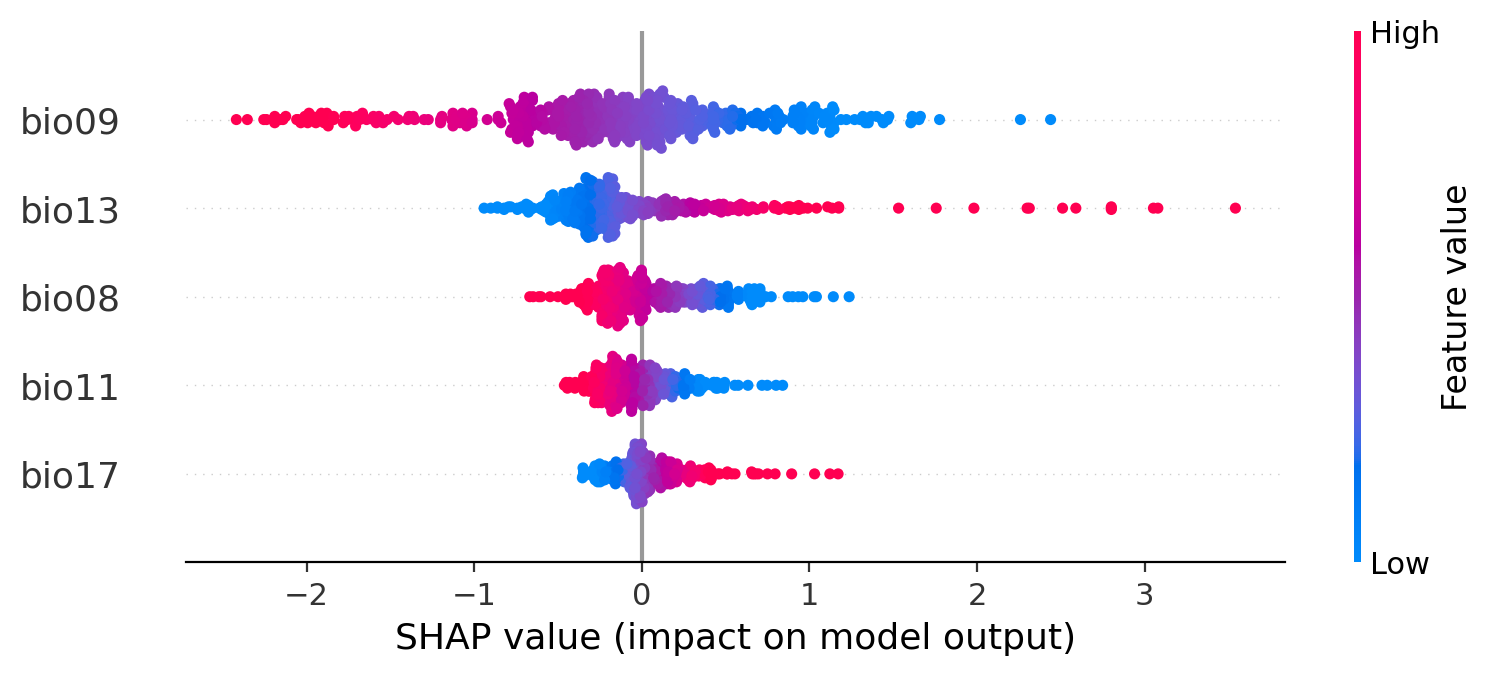

<Figure size 640x480 with 0 Axes>

In [35]:
shap.initjs()
shap.summary_plot(
    shap_all_values, X_all_scaled, class_names=CLASSES,
    color = lambda idx: COLOR_MAP[idx]
                 
)

Partial dependence plots - PDPs

  0%|          | 0/5 [00:00<?, ?it/s]

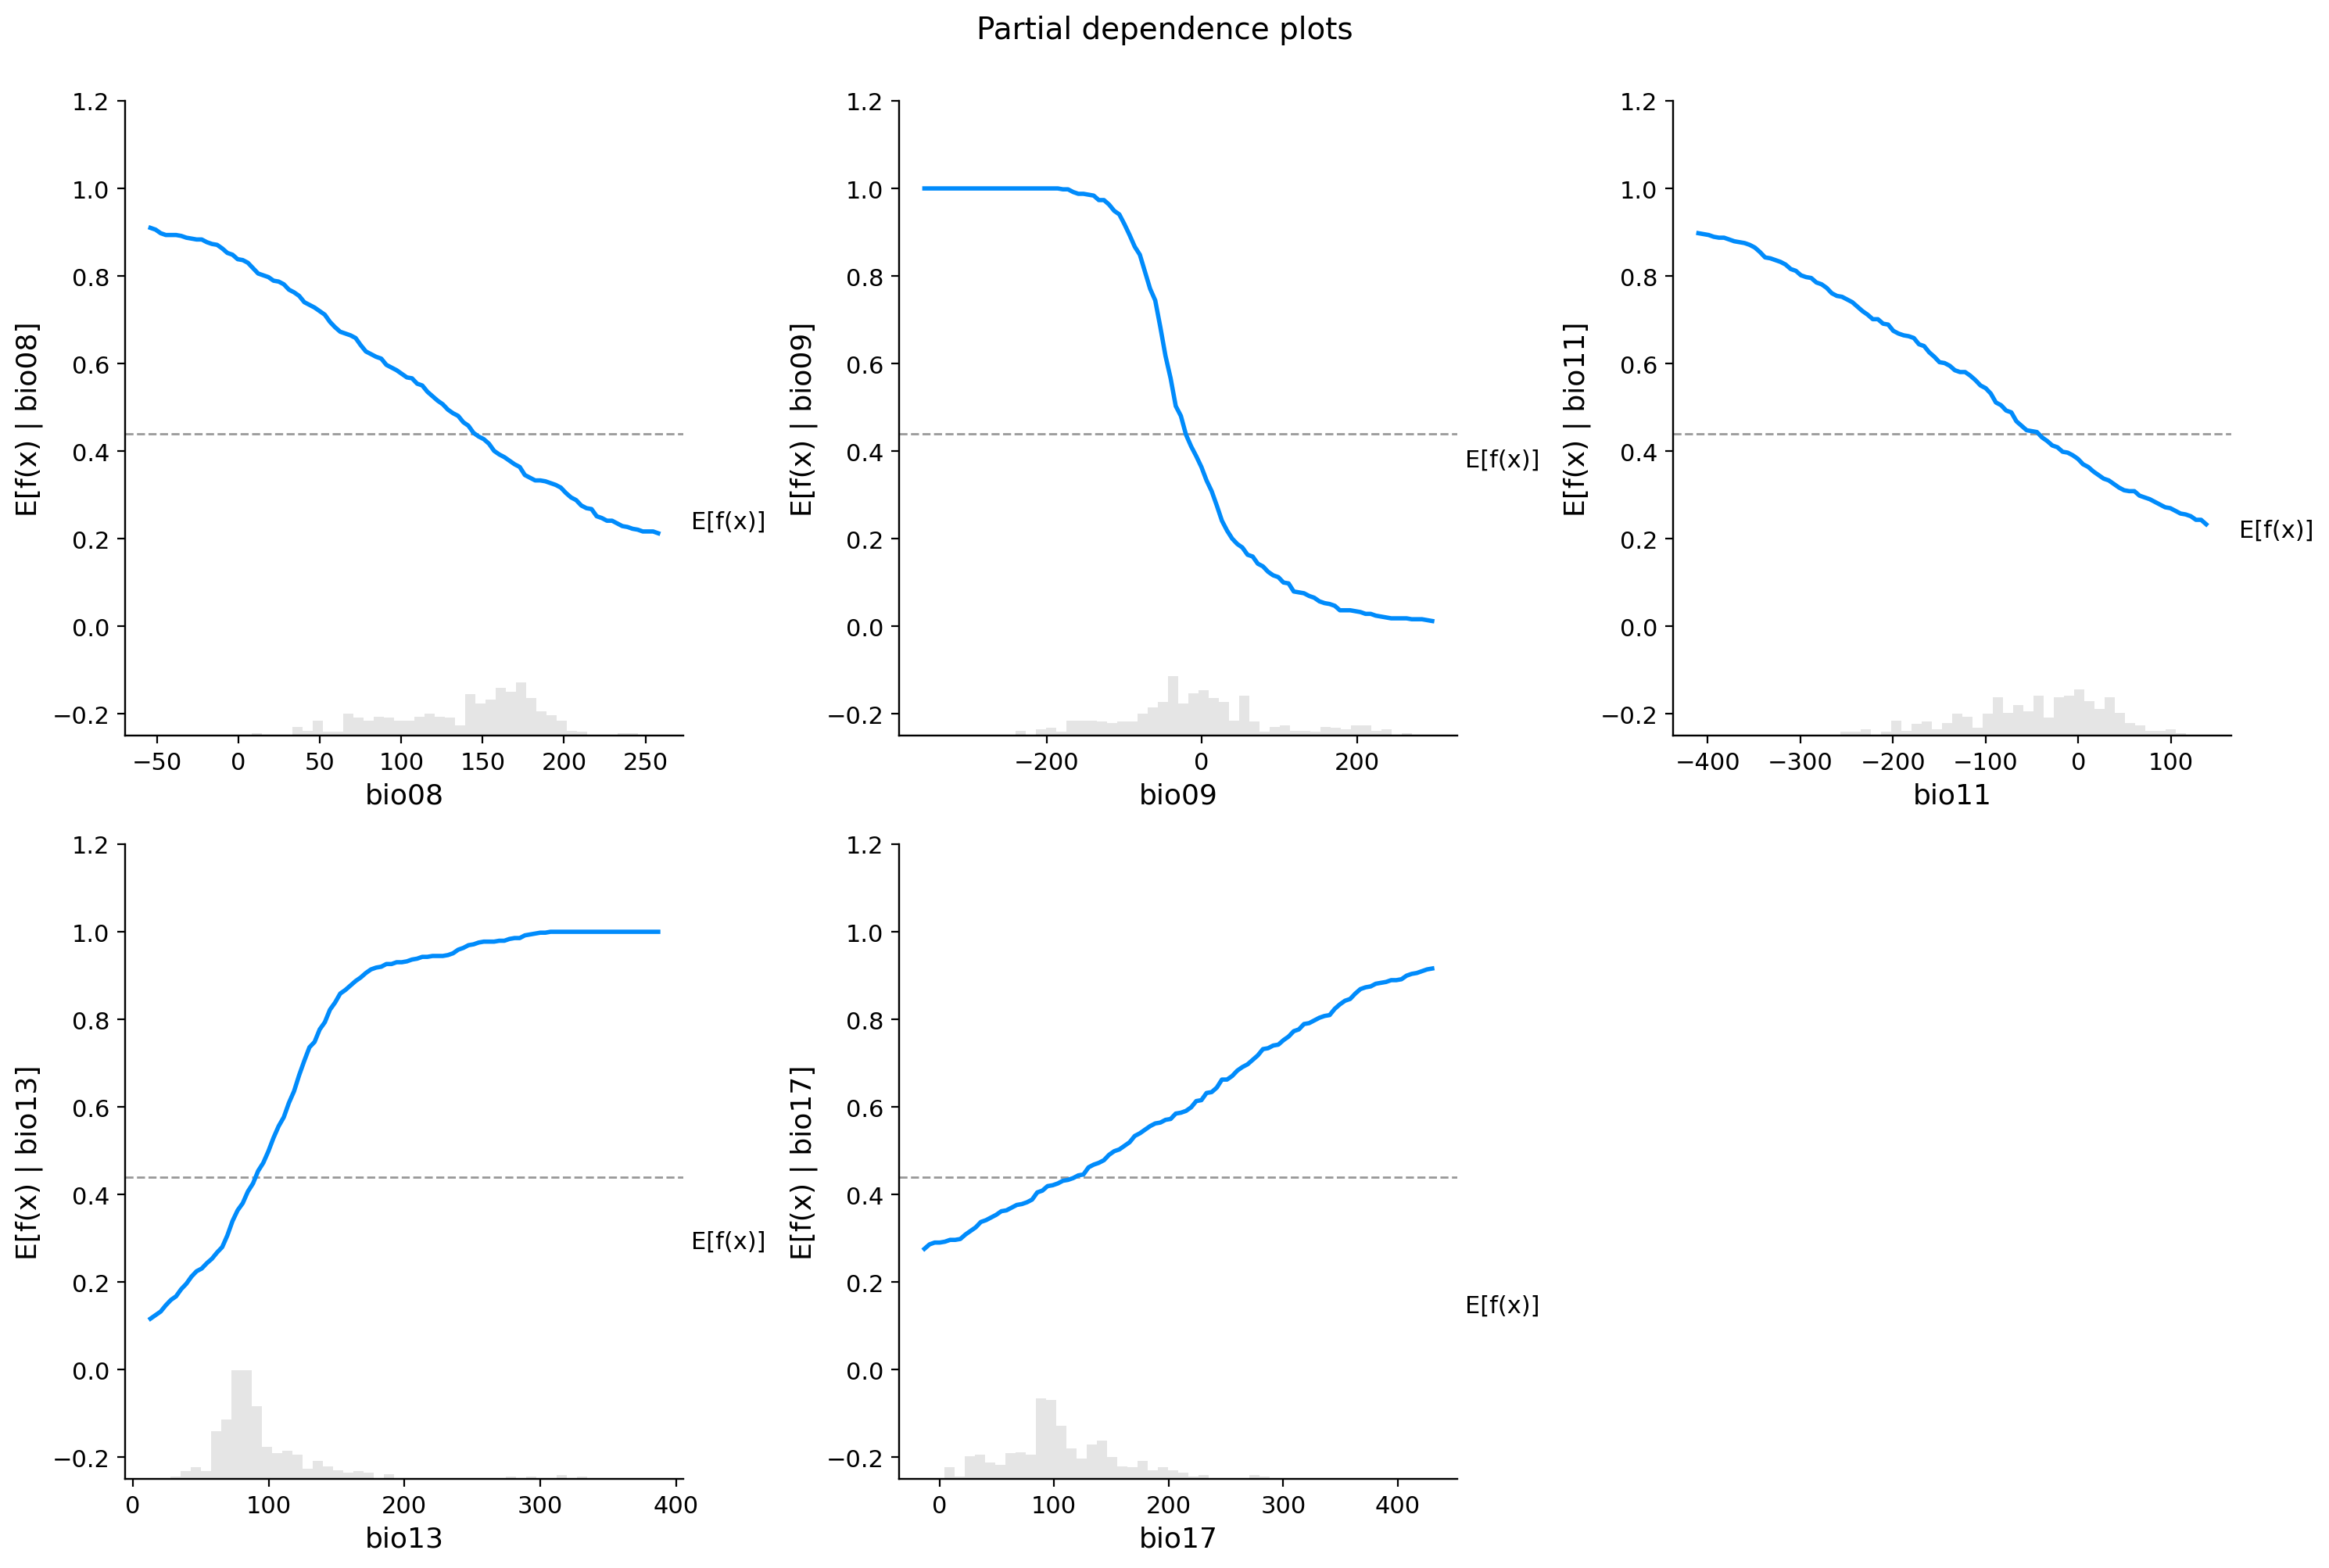

In [37]:
n_features = len(SELECTED_FEATURES)
n_cols = 3
n_rows = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize= (15, 10))

for feat_id, feat in tqdm.notebook.tqdm(enumerate(SELECTED_FEATURES), total=n_features):
    x_idx, y_idx = feat_id // (n_rows + 1), feat_id % n_cols 
    fig, ax = shap.partial_dependence_plot(
        feat,
        final_logreg.predict,
        X[SELECTED_FEATURES],
        shap_values=shap_values_test,
        model_expected_value=True,
        feature_expected_value=False,
        show=False,
        ice=False,
        ax=axes[x_idx][y_idx]

    )
    ax.set_ylim((-0.25, 1.2))

axes[-1][-1].axis("off")
plt.suptitle("Partial dependence plots", y = 1, fontsize=14)
plt.tight_layout()
plt.savefig("pdp_tri-pab.png", dpi=600)
plt.show()